In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
data_path = '/content/drive/My Drive/Datasets/60k_Stack_Overflow_Questions/data.csv'
data = pd.read_csv(data_path)
#data.Body = data.Body.map(lambda x: x.lstrip('<p>').rstrip('aAbBcC'))
data.head()

,Id,Title,Body,Tags,CreationDate,Y
0,34552656,Java: Repeat Task Every Random Seconds,<p>I'm already familiar with repeating tasks e...,<java><repeat>,2016-01-01 00:21:59,LQ_CLOSE
1,34552974,How to get all the child records from differen...,I am having 4 different tables like \r\nselect...,<sql><sql-server>,2016-01-01 01:44:52,LQ_EDIT
2,34553034,Why are Java Optionals immutable?,<p>I'd like to understand why Java 8 Optionals...,<java><optional>,2016-01-01 02:03:20,HQ
3,34553174,Text Overlay Image with Darkened Opacity React...,<p>I am attempting to overlay a title over an ...,<javascript><image><overlay><react-native><opa...,2016-01-01 02:48:24,HQ
4,34553318,Why ternary operator in swift is so picky?,"<p>The question is very simple, but I just cou...",<swift><operators><whitespace><ternary-operato...,2016-01-01 03:30:17,HQ


In [3]:
data.Body[3]

'<p>I am attempting to overlay a title over an image - with the image darkened with a lower opacity. However, the opacity effect is changing the overlaying text as well - making it dim. Any fix to this? Here is what is looks like:</p>\n\n<p><a href="https://i.stack.imgur.com/1HzD7.png" rel="noreferrer"><img src="https://i.stack.imgur.com/1HzD7.png" alt="enter image description here"></a></p>\n\n<p>And here is my code for the custom component (article preview - which the above image is a row of article preview components): </p>\n\n<pre><code>//component for article preview touchable image\n/* will require the following\n- rss feed and api\n- user\'s keyword interests from parse In home.js\n- parse db needs to be augmented to include what they heart\n- parse db needs to be augmented to include what they press on (like google news)\n*/\nvar React = require(\'react-native\');\nvar {\n  View, \n  StyleSheet, \n  Text, \n  Image, \n  TouchableHighlight, \n} = React;\n\n//dimensions\nvar Dime

In [4]:
import re

def cleanhtml(raw_html):
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', raw_html)
  cleantext = re.sub(r'([a-zA-Z0-9+._-]+@[a-zA-Z0-9._-]+\.[a-zA-Z0-9_-]+)', '', cleantext) 
  #regex to remove to emails(above)
  cleantext = re.sub(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '', cleantext)
  return cleantext

data.Body = data['Body'].apply(lambda x: cleanhtml(x))


In [5]:
X = data.Body
y = data.Y.map({'LQ_CLOSE':0,'LQ_EDIT':1,'HQ':2})

In [6]:
train_size = int(len(X) * 0.7)
X_train, y_train = X[0:train_size], y[0:train_size]
X_test, y_test = X[train_size:], y[train_size:]

print("X_train shape:",X_train.shape)
print("X_test shape:",X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (42000,)
X_test shape: (18000,)
y_train shape: (42000,)
y_test shape: (18000,)


In [7]:
vocab_size = 30000
embedding_dim = 16
max_length = 150

tokenizer = Tokenizer(vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
print(len(word_index))

172531


In [9]:
train_sequences = tokenizer.texts_to_sequences(X_train)

train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences,
                                                       padding='post',
                                                       maxlen=max_length,
                                                       truncating='post')

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length)

In [12]:
print(train_padded.shape)
print(test_padded.shape)

(42000, 150)
(18000, 150)


In [13]:
import math

def step_decay(epoch):
   initial_lrate = 0.1
   drop = 0.5
   epochs_drop = 10.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

In [14]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=(max_length)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
                             tf.keras.layers.Dropout(0.3),
                             tf.keras.layers.Dense(units=vocab_size/100, activation='relu'),
                             tf.keras.layers.Dense(3, activation='softmax')

])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           480000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 100)          26800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               60400     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               30300     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 903       
Total params: 598,403
Trainable params: 598,403
Non-trainable params: 0
__________________________________________________

In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])
history = model.fit(train_padded, y_train, epochs=10)

Epoch 1/10
1313/1313 [==============================] - 170s 129ms/step - loss: 0.3999 - accuracy: 0.8534
Epoch 2/10
1313/1313 [==============================] - 170s 129ms/step - loss: 0.3165 - accuracy: 0.8899
Epoch 3/10
1313/1313 [==============================] - 170s 129ms/step - loss: 0.2644 - accuracy: 0.9110
Epoch 4/10
1313/1313 [==============================] - 170s 130ms/step - loss: 0.2283 - accuracy: 0.9240
Epoch 5/10
1313/1313 [==============================] - 170s 129ms/step - loss: 0.1841 - accuracy: 0.9393
Epoch 6/10
1313/1313 [==============================] - 170s 129ms/step - loss: 0.1530 - accuracy: 0.9507
Epoch 7/10
1313/1313 [==============================] - 170s 129ms/step - loss: 0.1290 - accuracy: 0.9579
Epoch 8/10
1313/1313 [==============================] - 170s 130ms/step - loss: 0.1068 - accuracy: 0.9667
Epoch 9/10
1313/1313 [==============================] - 170s 130ms/step - loss: 0.0863 - accuracy: 0.9735
Epoch 10/10
1313/1313 [=======================

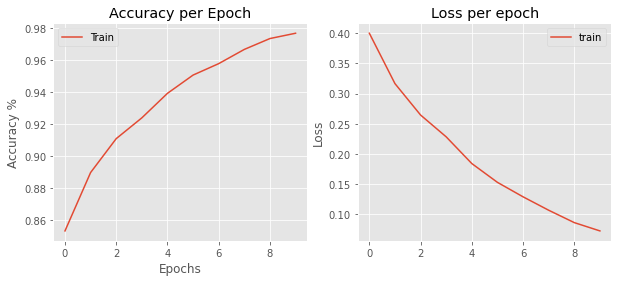

In [17]:
plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(10, 4), sharex=True)
ax1.plot(history.history['accuracy'], label='Train')
#ax1.plot(history.history['val_accuracy'],label='Validation')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy %')
ax1.set_title('Accuracy per Epoch')
ax1.legend()


ax2.plot(history.history['loss'], label='train')
#ax2.plot(history.history['val_loss'], label='validation')
ax2.set_ylabel("Loss")
ax2.set_title("Loss per epoch")
ax2.legend()

In [18]:
scores = model.evaluate(test_padded, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 80.86%


# Prediction of custom question data

In [20]:
#---PREDICT NEW TEXT---#
def get_encode(x):
    x = cleanhtml(x)
    x = tokenizer.texts_to_sequences(x)
    x = tf.keras.preprocessing.sequence.pad_sequences(x, maxlen=max_length, padding='post')
    return x

In [25]:
#How to predict our own text.
text=['<p>I want to write a bash script which takes different arguments. It should be used like normal linux console programs:</p><p>my_bash_script -p 2 -l 5 -t 20 So the value 2 should be saved in a variable called pages and the parameter l should be saved in a variable called length and the value 20 should be saved in a variable time.</p><p>What is the best way to do this?</p>']

text_sequences = tokenizer.texts_to_sequences(text)
text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_length)

text_padded.shape
y_pred = model.predict(text_padded)
y_pred = y_pred.round()
print(y_pred)

[[1. 0. 0.]]


In [26]:
text2 = ["<p>205</p><p> 108 I have a data frame with one column and Id like to split it into two columns, with one column header as 'fips' and the other 'row'</p><p>My dataframe df looks like this:</p><p> row 0 00000 UNITED STATES 1 01000 ALABAMA 2 01001 Autauga County, AL 3 01003 Baldwin County, AL 4 01005 Barbour County, AL I do not know how to use df.row.str[:] to achieve my goal of splitting the row cell. I can use df['fips'] = hello to add a new column and populate it with hello. Any ideas?</p><p> fips row 0 00000 UNITED STATES 1 01000 ALABAMA  2 01001 Autauga County, AL 3 01003 Baldwin County, AL 4 01005 Barbour County, AL</p>"]
text_sequences = tokenizer.texts_to_sequences(text2)
text2_padded = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_length)

text_padded.shape
y_pred = model.predict(text2_padded)
y_pred = y_pred.round()
print(y_pred)

[[0. 1. 0.]]


In [27]:
text=["I accidentally committed the wrong files to Git, but I haven't pushed the commit to the server yet.How can I undo those commits from the local repository?"]

text_sequences = tokenizer.texts_to_sequences(text)
text_padded = tf.keras.preprocessing.sequence.pad_sequences(text_sequences, maxlen=max_length)

text_padded.shape
y_pred = model.predict(text_padded)
print(y_pred)

[[0.26428354 0.02285744 0.712859  ]]
